In [43]:
import random
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import gym_minigrid
from gym_minigrid.minigrid import Wall, Door, Key, Ball
from gym_minigrid.wrappers import *
from gym_minigrid.window import Window
from skimage.transform import resize

env = gym.make("MiniGrid-BlockedUnlockPickup-v0")

In [2]:
# DISCOUNTED FACTOR
gamma = 0.95

# PARAMS GAME
num_episodes = 100
buffer_size = 10000
mini_batch_size = 32
steps_per_target_update = 5
batch_size = 4

# PARAMS NEURAL NETWKORK
learning_rate = 0.0001
cropped_state_size = [64, 128, 3]
num_input_neurons = cropped_state_size[0]
num_ouptut_neurons = env.action_space.n
common_net_hidden_dimensions = [16, 64]

# For saving in csv file the rewards
import pandas as pd
raw_data = {'episode_number':[], 'total_reward':[]}

In [3]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [4]:
def preprocess_frame(frame):
    # Crop the screen (remove part that contains no information)
    # [Up: Down, Left: right]
    cropped_frame = frame[36:-36, 36:-36]

    rgb = resize(cropped_frame, cropped_state_size)
    return rgb

In [11]:
class DDQN:
    def __init__(self,
                 session,
                 scope_name,
                 input_size,
                 hidden_layer_sizes,
                 output_size,
                 learning_rate,
                 state_size):

        self.session = session
        self.scope_name = scope_name
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate

        with tf.variable_scope(self.scope_name, reuse=tf.AUTO_REUSE):
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")

            # Input is 100x120x1
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_,
                                          filters=32,
                                          kernel_size=[8, 8],
                                          strides=[4, 4],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="conv1",
                                          )

            self.conv1_out = tf.nn.relu(self.conv1, name="conv1_out")

            """
            Second convnet: CNN RELU
            """
            self.conv2 = tf.layers.conv2d(inputs=self.conv1_out,
                                          filters=64,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="conv2")

            self.conv2_out = tf.nn.relu(self.conv2, name="conv2_out")

            """
            Third convnet: CNN RELU
            """
            self.conv3 = tf.layers.conv2d(inputs=self.conv2_out,
                                          filters=128,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="conv3")

            self.conv3_out = tf.nn.relu(self.conv3, name="conv3_out")

            self.flatten = tf.layers.flatten(self.conv3_out)

            # Separating streams into advantage and value networks
            adv_net = tf.layers.dense(self.flatten, 32, activation=tf.nn.relu)
            adv_net = tf.layers.dense(adv_net, self.output_size)

            val_net = tf.layers.dense(self.flatten, 32, activation=tf.nn.relu)
            val_net = tf.layers.dense(val_net, 1)

            self.output = val_net + (adv_net - tf.reduce_mean(adv_net,
                                                              reduction_indices=1,
                                                              keepdims=True))

            # Placeholder for expected q-values
            self.y = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)

            # Using the loss method provided by tf directly
            self.loss = tf.losses.mean_squared_error(self.y, self.output)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=self.learning_rate).minimize(self.loss)

    def predict(self, state):
        return self.session.run(self.output,
                                feed_dict={self.inputs_: state})

    def update(self, state, y):
        return self.session.run([self.loss, self.optimizer],
                                feed_dict={
                                    self.inputs_: state,
                                    self.y: y
                                })

In [40]:
def train_dqn(main_dqn, mini_batch):
    """
    param: mini_batch: From the randomly sampled minbatch from replay-buffer,
                       it's a list of experiences in the form of
                       `(state, action, reward, next_state, done)`
    """
    states = np.array([x[0] for x in mini_batch])

    actions = np.array([x[1] for x in mini_batch])
    rewards = np.array([x[2] for x in mini_batch])
    next_states = np.array([x[3] for x in mini_batch])
    done = np.array([x[4] for x in mini_batch])

    # For double DQN: select the best action for next state
    Qs_batch = []

    # Get Q values for next_state
    main_output_next_states = main_dqn.predict(np.squeeze(next_states))

    # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a')
    for i in range(0, mini_batch_size):
        terminal = done[i]

        # We got a'
        action = np.argmax(main_output_next_states[i])

        # If we are in a terminal state, only equals reward
        if terminal:
            Qs_batch.append(rewards[i])

        else:
            # Take the Q for action a'
            q = rewards[i] + gamma * main_output_next_states[i][action]
            Qs_batch.append(q)

    targets_mb = np.array([each for each in Qs_batch])

    main_output = main_dqn.predict(np.squeeze(states))
    main_output[np.arange(len(states)), actions] = targets_mb

    loss, optimizer = main_dqn.update(np.squeeze(states), main_output)

    return loss

In [41]:
tf.reset_default_graph()

replay_buffer = deque(maxlen=buffer_size)
last_n_rewards = deque(maxlen=num_episodes)
rewards = deque(maxlen=num_episodes)
losses = deque(maxlen=num_episodes)

# Initialize deque with zero-images one array for each image
stacked_frames = deque([np.zeros((cropped_state_size[0], cropped_state_size[1], cropped_state_size[2]), dtype=np.int) for i in range(4)], maxlen=4)

Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  5
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  5
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  5
Ep numbe

Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep numbe

Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  5
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  5
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  5
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep numbe

Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  1
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  3
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  2
Ep numbe

Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  0
Ep number:  0  Action reward:  0  Total reward:  0 Action:  4
Ep number:  0  Action reward:  0  Total reward:  0 Action:  6
Ep number:  0  Action reward:  -1  Total reward:  -1 Action:  4
Episode number:  0  with total reward:  -1
Loss:  0.00019772304
Model Saved
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Act

Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  2
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  2
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep numbe

Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  2
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep numbe

Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  2
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  4
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  6
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  3
Ep number:  1  Action reward:  0  Total reward:  0 Action:  0
Ep number:  1  Action reward:  0  Total reward:  0 Action:  2
Ep number:  1  Action reward:  0  Total reward:  0 Action:  5
Ep number:  1  Action reward:  0  Total reward:  0 Action:  1
Ep numbe

Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep numbe

Ep number:  2  Action reward:  0  Total reward:  0 Action:  4
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  4
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep numbe

Ep number:  2  Action reward:  0  Total reward:  0 Action:  4
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep number:  2  Action reward:  0  Total reward:  0 Action:  4
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  2
Ep number:  2  Action reward:  0  Total reward:  0 Action:  3
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  0
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  6
Ep number:  2  Action reward:  0  Total reward:  0 Action:  4
Ep number:  2  Action reward:  0  Total reward:  0 Action:  1
Ep number:  2  Action reward:  0  Total reward:  0 Action:  5
Ep numbe

Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  6
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep numbe

Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  6
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep numbe

Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  6
Ep numbe

Ep number:  3  Action reward:  0  Total reward:  0 Action:  1
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  6
Ep number:  3  Action reward:  0  Total reward:  0 Action:  6
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  2
Ep number:  3  Action reward:  0  Total reward:  0 Action:  5
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  0
Ep number:  3  Action reward:  0  Total reward:  0 Action:  3
Ep number:  3  Action reward:  0  Total reward:  0 Action:  4
Ep numbe

Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  6
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  6
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep number:  4  Action reward:  0  Total reward:  0 Action:  5
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  5
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep numbe

Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  5
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  4
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  6
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  3
Ep numbe

Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep number:  4  Action reward:  0  Total reward:  0 Action:  5
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  6
Ep number:  4  Action reward:  0  Total reward:  0 Action:  1
Ep number:  4  Action reward:  0  Total reward:  0 Action:  2
Ep number:  4  Action reward:  0  Total reward:  0 Action:  5
Ep number:  4  Action reward:  0  Total reward:  0 Action:  6
Ep number:  4  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep numbe

Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep numbe

Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  3
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  4
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  2
Ep number:  5  Action reward:  0  Total reward:  0 Action:  5
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  6
Ep number:  5  Action reward:  0  Total reward:  0 Action:  1
Ep number:  5  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  6
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  6
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep numbe

Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  6
Ep number:  6  Action reward:  0  Total reward:  0 Action:  6
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep numbe

Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  5
Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep numbe

Ep number:  6  Action reward:  0  Total reward:  0 Action:  3
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  4
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  1
Ep number:  6  Action reward:  0  Total reward:  0 Action:  6
Ep number:  6  Action reward:  0  Total reward:  0 Action:  0
Ep number:  6  Action reward:  0  Total reward:  0 Action:  2
Ep numbe

Ep number:  7  Action reward:  0  Total reward:  0 Action:  2
Ep number:  7  Action reward:  0  Total reward:  0 Action:  6
Ep number:  7  Action reward:  0  Total reward:  0 Action:  1
Ep number:  7  Action reward:  0  Total reward:  0 Action:  3
Ep number:  7  Action reward:  0  Total reward:  0 Action:  4
Ep number:  7  Action reward:  0  Total reward:  0 Action:  2
Ep number:  7  Action reward:  0  Total reward:  0 Action:  1
Ep number:  7  Action reward:  0  Total reward:  0 Action:  1
Ep number:  7  Action reward:  0  Total reward:  0 Action:  0
Ep number:  7  Action reward:  0  Total reward:  0 Action:  2
Ep number:  7  Action reward:  0  Total reward:  0 Action:  4
Ep number:  7  Action reward:  0  Total reward:  0 Action:  6
Ep number:  7  Action reward:  0  Total reward:  0 Action:  6
Ep number:  7  Action reward:  0  Total reward:  0 Action:  3
Ep number:  7  Action reward:  0  Total reward:  0 Action:  4
Ep number:  7  Action reward:  0  Total reward:  0 Action:  0
Ep numbe

KeyboardInterrupt: 

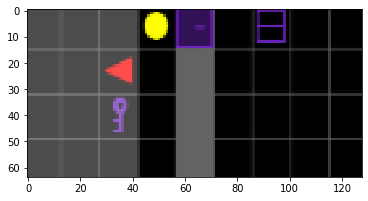

In [44]:
with tf.Session() as sess:
    main_dqn = DDQN(session=sess,
                     scope_name="q_main",
                     input_size=num_input_neurons,
                     hidden_layer_sizes=common_net_hidden_dimensions,
                     output_size=num_ouptut_neurons,
                     learning_rate=learning_rate,
                     state_size=cropped_state_size)

    # Saver will help us to save our model
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    # Load the model
    #saver.restore(sess, tf.train.latest_checkpoint('models'))

    # Some counter for training cycle
    counter = 1
    try:
        for ep_num in range(0,num_episodes):
            env.reset()
            done = False
            episode_reward, loss, steps = 0, 0, 0
            episode_loss = []

            # epsilon decay
            epsilon = 1. / ((ep_num / 10) + 1)

            while not done:
                state = preprocess_frame(env.render(mode='rgb_array'))
                plt.imshow(state)
                # select the action
                action = None
                if np.random.rand() < epsilon:
                    action = random.randint(0, env.action_space.n-1)
                else:                    
                    action = np.argmax(main_dqn.predict(state.reshape((1, *state.shape))))

                # execute the action
                obs, reward, done, info = env.step(action)
                next_state = preprocess_frame(env.render(mode='rgb_array'))
                
                if done:
                    reward += -1
                # add to the buffer
                replay_buffer.append((state, action, reward, next_state, done))

                # sample from the buffer and train
                if counter > mini_batch_size:
                    mini_batch = random.sample(replay_buffer, (mini_batch_size))
                    loss = train_dqn(main_dqn, mini_batch)
                    episode_loss.append(loss)

                counter +=1
                episode_reward += reward
                steps += 1
                state = next_state
                print("Ep number: ", ep_num, " Action reward: ", reward, " Total reward: ", episode_reward, "Action: ", action)
            print("Episode number: ", ep_num, " with total reward: ", episode_reward)
            print("Loss: ", np.mean(episode_loss))

            last_n_rewards.append(episode_reward)
            last_n_avg_reward = np.mean(last_n_rewards)
            rewards.append(episode_reward)
            losses.append(np.mean(episode_loss))

            # Save model every 5 episodes
            if ep_num % 5 == 0:
                save_path = saver.save(sess, "models/model.ckpt")
                print("Model Saved")
                # Saving results into csv
                raw_data['episode_number'] = np.array(rewards)
                raw_data['total_reward'] = np.arange(len(rewards))
                df = pd.DataFrame(raw_data, columns=raw_data.keys())
                if not os.path.exists("models/results.csv"):
                    df.to_csv("models/results.csv", sep="\t")
                else:
                    df_old = pd.read_csv("models/results.csv", sep = ";")
                    df = df.append(df_old, ignore_index=True)
    except KeyboardInterrupt:
        print("SIGINT interception")
        save_path = saver.save(sess, "models/model.ckpt")
        print("Model Saved")
        # Saving results into csv
        raw_data['episode_number'] = np.array(rewards)
        raw_data['total_reward'] = np.arange(len(rewards))
        df = pd.DataFrame(raw_data, columns=raw_data.keys())
        if not os.path.exists("models/results.csv"):
            df.to_csv("models/results.csv", sep="\t")
        else:
            df_old = pd.read_csv("models/results.csv", sep = ";")
            df = df.append(df_old, ignore_index=True)
        pass

